# Compare against FastText baseline

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, sys, time
from tqdm import tqdm
from collections import OrderedDict

from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# https://matplotlib.org/examples/color/named_colors.html

from utils import timed_func, combine_df, groupby_return_df

In [3]:
archive = "../src/archive"
ft_df = combine_df(os.path.join(archive, "20200521_en_fr_es_fasttext"))
print(ft_df.shape)
ft_df.head()

(2376, 15)


,lm,lang,task,layer,dim,batch_size,init_lr*1e6,weight_decay,lr_anneal,max_grad_step,train_steps,seed,devloss,testloss,acc
0,fasttext,en,probe,0,10,32,100.0,0.0,0.5,96000,71175,73,2.653320,2.657866,24.816146
1,fasttext,en,probe,0,10,32,100.0,0.0,0.5,96000,33215,421,2.463619,2.480077,30.782416
2,fasttext,es,probe,0,10,32,100.0,0.0,0.5,96000,96000,73,2.564169,2.568047,22.291537
3,fasttext,en,probe,0,10,32,100.0,0.0,0.5,96000,37960,9973,2.584604,2.595099,21.913188
4,fasttext,fr,probe,0,10,32,100.0,0.0,0.5,96000,96000,73,2.747837,2.745423,9.641991


In [4]:
3*(5+5+1)*(6*4*3)

2376

In [5]:
print(ft_df[ft_df.lang=="en"].shape)
print(ft_df[ft_df.lang=="fr"].shape)
print(ft_df[ft_df.lang=="es"].shape)

(792, 15)
(792, 15)
(792, 15)


In [6]:
def groupby_return_df(df, group_features, task_features):
    dfs = {}
    for ft in group_features:
        dfs[ft] = []
    for ft in task_features:
        dfs[ft] = []
    df_with_mean = df.groupby(group_features).mean()
    for idx, row in df_with_mean.iterrows():
        for j, ft in enumerate(group_features):
            dfs[ft].append(idx[j])
        for j, ft in enumerate(task_features):
            dfs[ft].append(row[ft])
    return pd.DataFrame(dfs)
    
df_with_mean = groupby_return_df(
    ft_df[ft_df.lang=="en"],
    ["lang", "task", "layer", "dim", "init_lr*1e6", "max_grad_step"],
    ["devloss", "testloss", "acc"]
)
print(df_with_mean.shape)
df_with_mean[["layer", "dim"]].drop_duplicates()

(198, 9)


,layer,dim
0,0,10
6,1,10
12,1,20
18,1,40
24,1,80
30,1,160
36,2,10
42,2,20
48,2,40
54,2,80


In [14]:
def plot_by_config_one_fig(df_with_mean, category="acc", lang="en"):
    res_ = {(0, 10): [], (1,10): [], (1,20): [], (1, 40): [], (1, 80): [], (1, 160): [],
          (2, 10): [], (2, 20): [], (2, 40): [], (2, 80): [], (2, 160): []}
    res = OrderedDict(res_)
    plt.figure(figsize=(8,10))
    for config in res:
        layer, dim = config
        df_tmp = df_with_mean[(df_with_mean.layer == layer) & (df_with_mean.dim == dim) & \
                              (df_with_mean.max_grad_step == 96000)]
        df_probe = df_tmp[df_tmp.task == "probe"].sort_values(["init_lr*1e6"])
        df_crep = df_tmp[df_tmp.task == "crep"].sort_values(["init_lr*1e6"])
        df_ctarget = df_tmp[df_tmp.task == "ctarget"].sort_values(["init_lr*1e6"])
        
        x = df_probe["init_lr*1e6"] / (10**6)
        if category == "acc":
            y = df_probe["acc"]
            ylabel = "Accuracy"
        elif category == "loss":
            y = df_probe["testloss"]
            ylabel = "Loss"
        elif category == "hewitt":
            y = df_probe["acc"].values - df_ctarget["acc"].values
            ylabel = "Diff accuracy"
        elif category == "pimentel":
            y = -df_probe["testloss"].values + df_crep["testloss"].values
            ylabel = "Diff loss"
        else:
            raise ValueError
        title = f"FastText: {ylabel} vs initial learning rate ({lang})"
            
        if len(df_tmp) > 0:
            if layer == 0:
                c_ = {10: colors["cyan"]}
            elif layer == 1:
                c_ = {10: colors["darkgreen"], 20: colors["green"], 40: colors["seagreen"], 80: colors["limegreen"], 160: colors["yellowgreen"]}
            else:
                c_ = {10: colors["magenta"], 20: colors["violet"], 40: colors["deeppink"], 80: colors["hotpink"], 160: colors["pink"]}
            plt.plot(x, y, label="layer{} dim{}".format(layer, dim), c=c_[dim], linestyle="dashdot")
    plt.ylabel(ylabel)
    plt.xlabel("init_lr")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    
    plt.savefig("0522_fasttext/fasttext_{}_learning_rate_{}.png".format(category, lang), dpi=300)

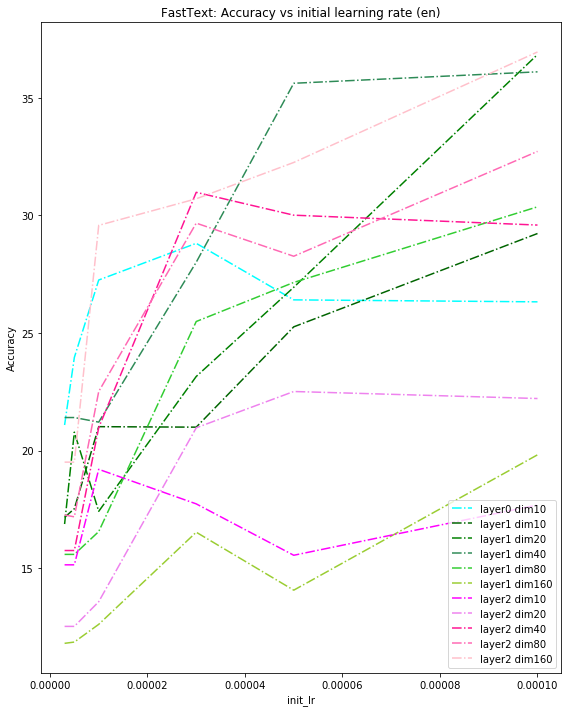

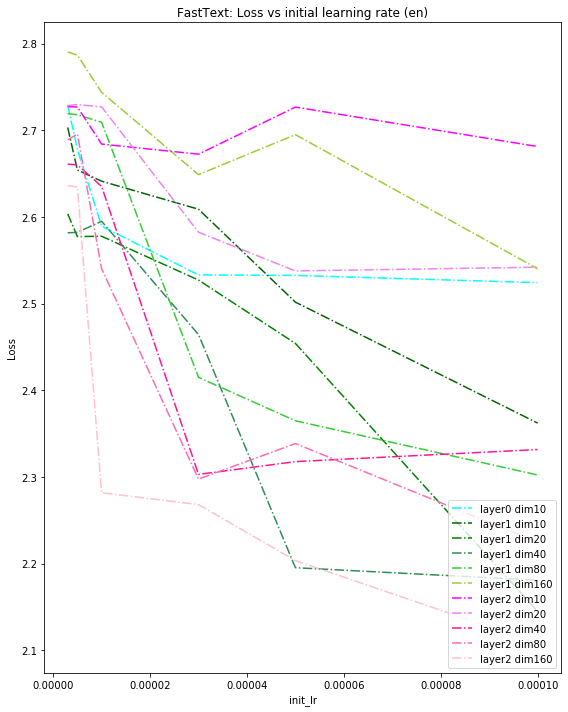

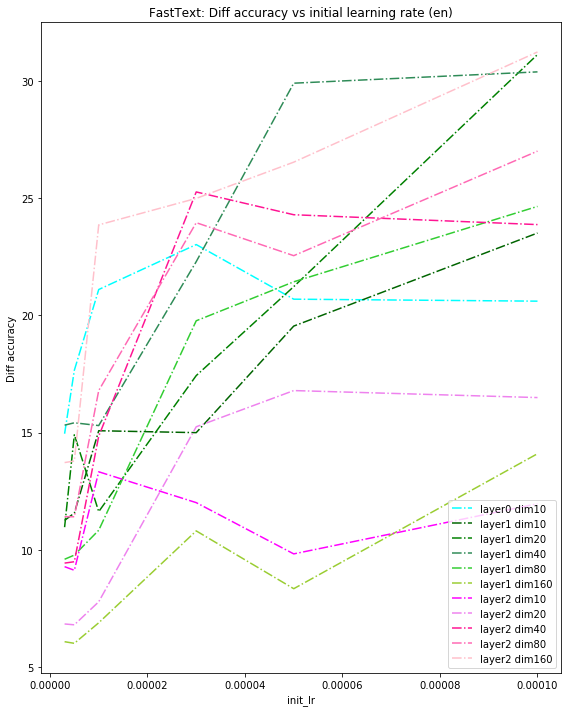

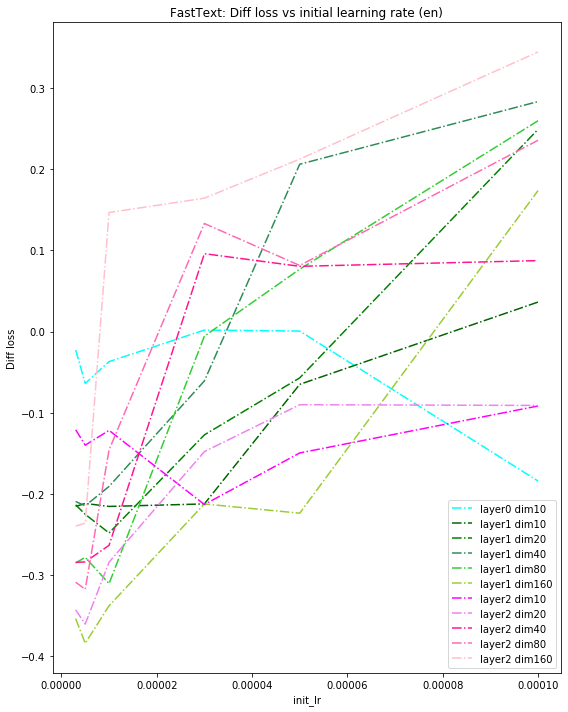

In [15]:
plot_by_config_one_fig(df_with_mean, "acc", "en")
plot_by_config_one_fig(df_with_mean, "loss", "en")
plot_by_config_one_fig(df_with_mean, "hewitt", "en")
plot_by_config_one_fig(df_with_mean, "pimentel", "en")